### Main class to run the Algorithm

In [36]:
from Bellman_Ford import Graph
from Bellman_Ford import load_data
import matplotlib.pyplot as plt
import networkx as nx
import time 
import json 
import math
from itertools import combinations
import random



### Load in the data

In [37]:
def load_airport_data(json_path):
    """
    Load airport data from JSON file.
    :param json_path: Path to the JSON file.
    :return: Dictionary with airports and graph edges.
    """
    with open(json_path, 'r') as file:
        data = json.load(file)
    airports = {entry["IATA"]: entry for entry in data}
    return airports

json_path = r"C:\Users\sudersanamv\vs code\BELLMAN-FORD-ALGORITHM\28k airports data\1777_airports.json"
airports = load_airport_data(json_path)


### Haversine Formula to calculate the distances using Latitude and Longitude

In [38]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points using the Haversine formula.
    :param lat1: Latitude of the first point in decimal degrees
    :param lon1: Longitude of the first point in decimal degrees
    :param lat2: Latitude of the second point in decimal degrees
    :param lon2: Longitude of the second point in decimal degrees
    :return: Distance between the two points in kilometers
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [39]:
def calculate_distances(airports):
    """
    Calculate distances between all airport pairs using the Haversine formula.
    :param airports: List of airport data with IATA codes, latitudes, and longitudes
    :return: Dictionary of distances between airport pairs
    """
    distances = {}
    for (iata1, data1), (iata2, data2) in combinations(airports.items(), 2):
        lat1, lon1 = data1["LAT"], data1["LONG"]
        lat2, lon2 = data2["LAT"], data2["LONG"]
        distance = haversine(lat1, lon1, lat2, lon2)
        distances[(iata1, iata2)] = distance
    return distances


In [40]:
# Calculate distances and save them for future use
distances = calculate_distances(airports)

# Convert tuple keys to strings
distances_str_keys = {f"{k[0]}-{k[1]}": v for k, v in distances.items()}

# Store the distances in a file
output_file = "airport_distances.json"
with open(output_file, 'w') as file:
    json.dump(distances_str_keys, file, indent=4)

print(f"Distances between airports have been saved to {output_file}")


Distances between airports have been saved to airport_distances.json


### Visualization of Bellman-Ford Algorithm

In [74]:
# Load distances from airport_distances.json
def load_distances(file_path):
    """
    Load airport distances from a JSON file.
    :param file_path: Path to the JSON file
    :return: Dictionary of distances
    """
    with open(file_path, 'r') as file:
        distances = json.load(file)
    return distances


In [75]:
# Function to create the graph
def create_graph(distances):
    """
    Create a NetworkX graph from the distances dictionary.
    :param distances: Dictionary of distances between airports
    :return: A NetworkX graph
    """
    G = nx.DiGraph()
    for edge, weight in distances.items():
        source, destination = edge.split('-')
        G.add_edge(source, destination, weight=weight)
    return G


In [76]:
# Visualization function
def visualize_bellman_ford(G, source):
    """
    Visualize the Bellman-Ford algorithm step by step.
    :param G: A NetworkX graph
    :param source: The source airport (node)
    """
    # Get positions for consistent graph layout
    pos = nx.circular_layout(G, scale=2)

    # Initialize distances
    distances = {node: float('inf') for node in G.nodes()}
    distances[source] = 0

     # Round edge weights to 1 decimal place
    rounded_weights = {edge: round(weight, 1) for edge, weight in nx.get_edge_attributes(G, 'weight').items()}

    # Draw the initial graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True, node_color='lightblue', font_weight='bold',
        node_size=1000, edge_color='gray', arrowsize=15
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_weights)
    plt.title("Initial Graph Setup", fontsize=16)
    plt.show()

        # Relax edges for |V| - 1 iterations
    for i in range(len(G.nodes()) - 1):
        print(f"Iteration {i + 1}:")
        updated = False
        for u, v, data in G.edges(data=True):
            if isinstance(data, dict):
                weight = data.get('weight', 0)
            else:
                weight = data  # Directly use the float if data is not a dict

            if distances[u] != float('inf') and distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                updated = True

                # Visualize the current relaxation step
                plt.figure(figsize=(12, 8))
                node_colors = ['green' if node == source else 'lightblue' for node in G.nodes()]
                nx.draw(
                    G, pos, with_labels=True, node_color=node_colors, font_weight='bold',
                    node_size=1000, edge_color='gray', arrowsize=15
                )
                nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_weights)
                plt.title(f"Iteration {i + 1}: Relaxing edge {u} -> {v}, Distance[{v}] = {distances[v]:.1f}", fontsize=16)
                plt.show()

        if not updated:
            print("No updates in this iteration. Algorithm converged.")
            break

    # Final distances
    print("Final distances from source:", {k: round(v, 1) for k, v in distances.items()})

### Random Airport Selection

In [77]:
# Select 10 random airports for visualization
def select_random_airports(distances, num_airports):
    """
    Select a subset of airports and their distances for easier visualization.
    :param distances: Dictionary of all distances
    :param num_airports: Number of airports to include
    :return: Filtered distances for the selected airports
    """
    airports = set()
    for edge in distances.keys():
        airports.update(edge.split('-'))
    selected_airports = random.sample(list(airports), num_airports)

    filtered_distances = {
        edge: weight for edge, weight in distances.items()
        if all(airport in selected_airports for airport in edge.split('-'))
    }
    return filtered_distances

Selected source airport: CEV


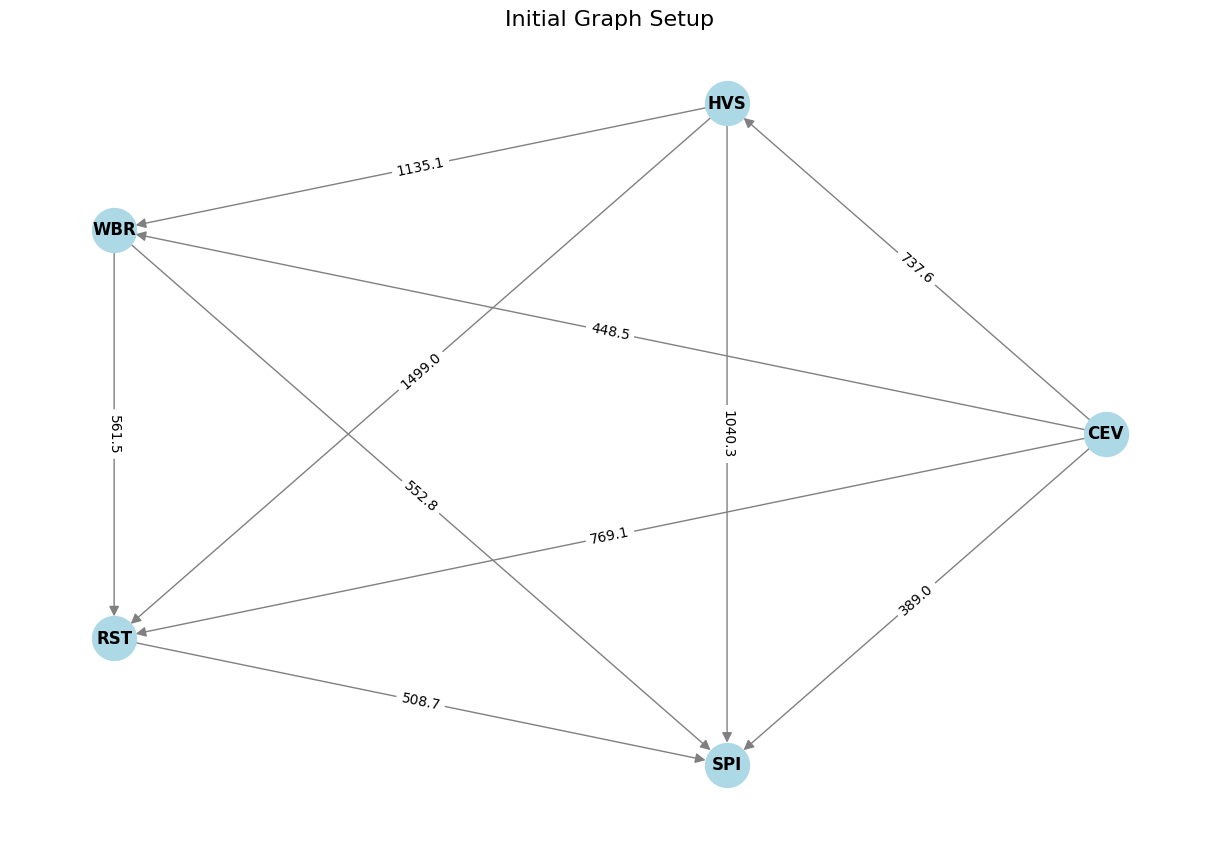

Iteration 1:


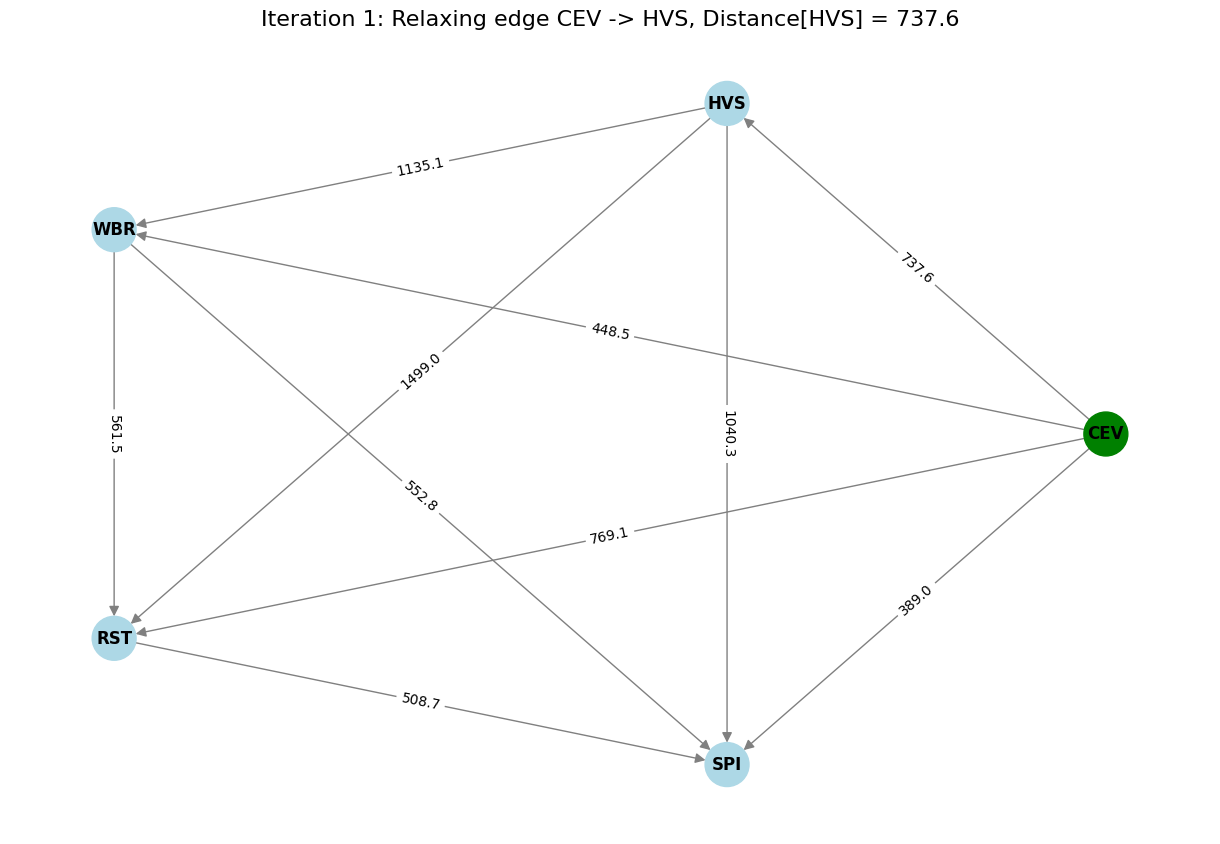

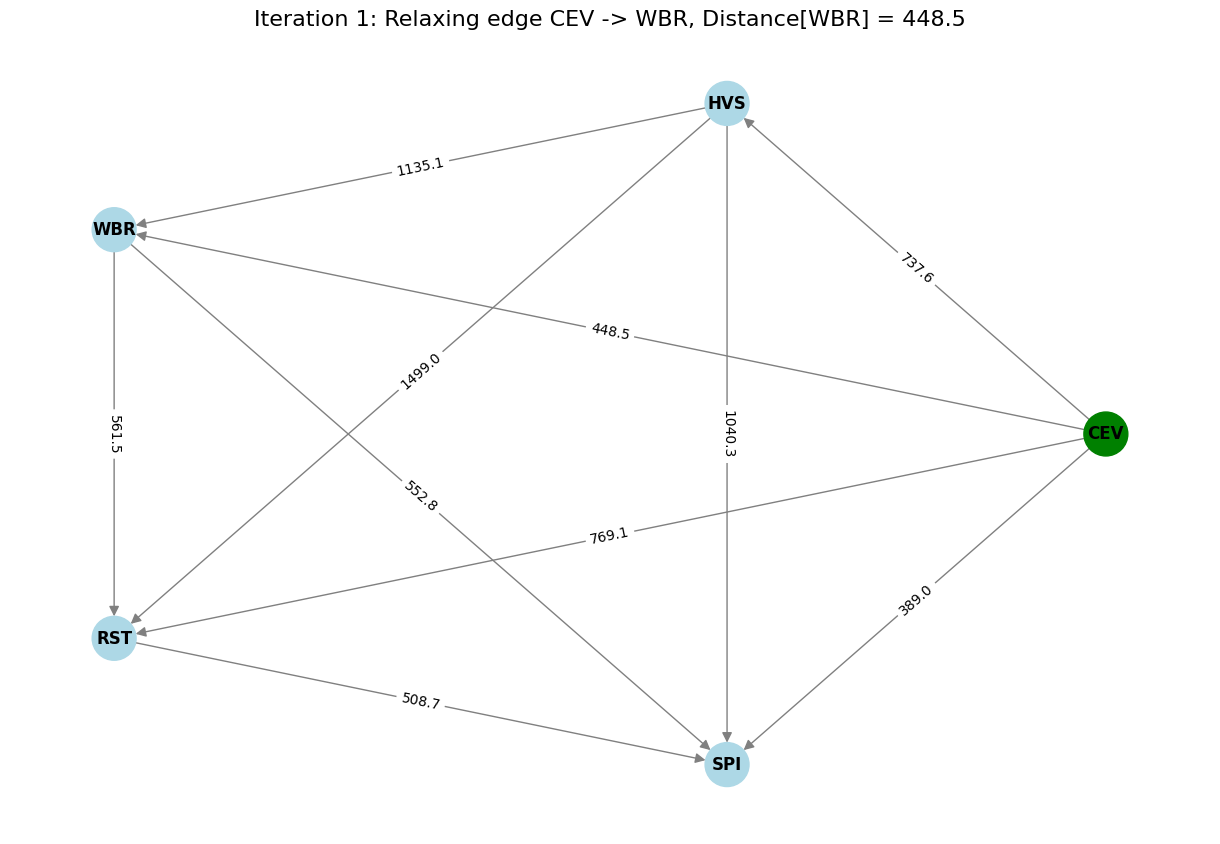

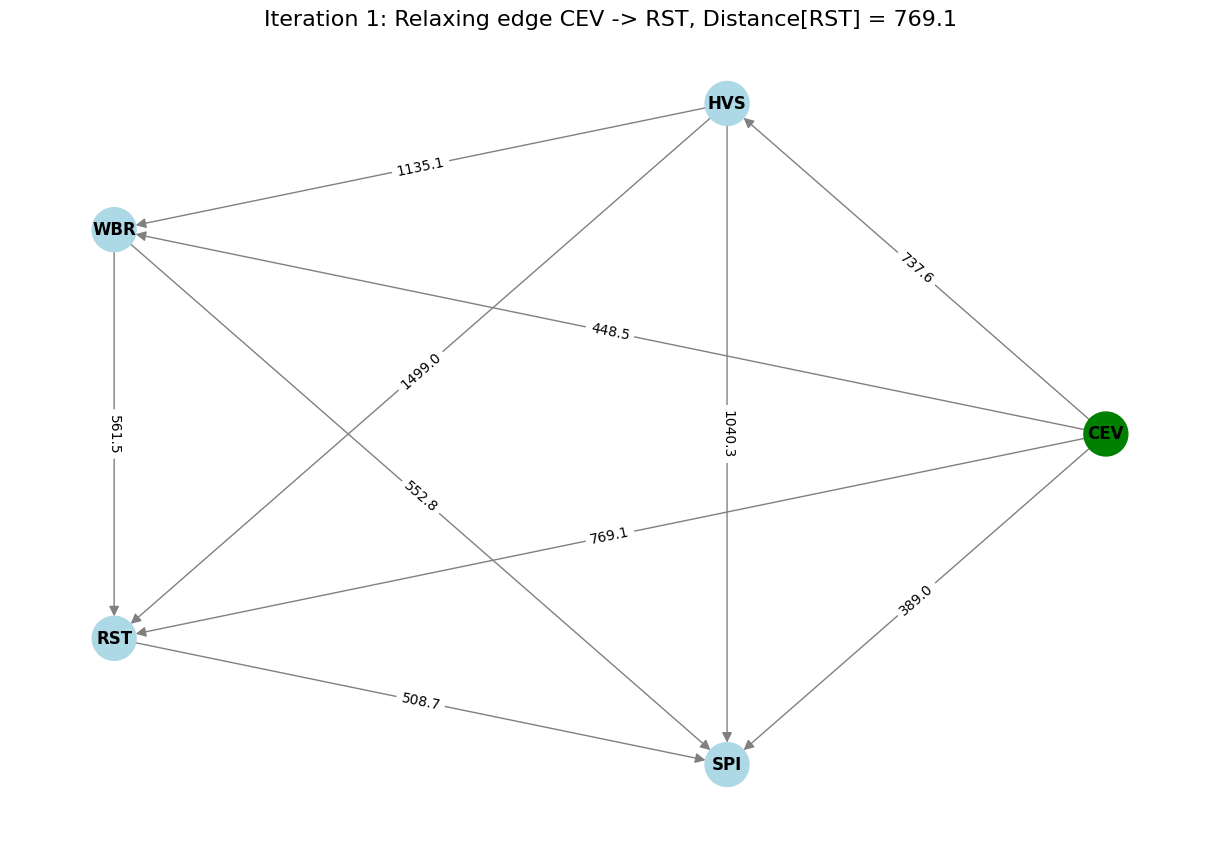

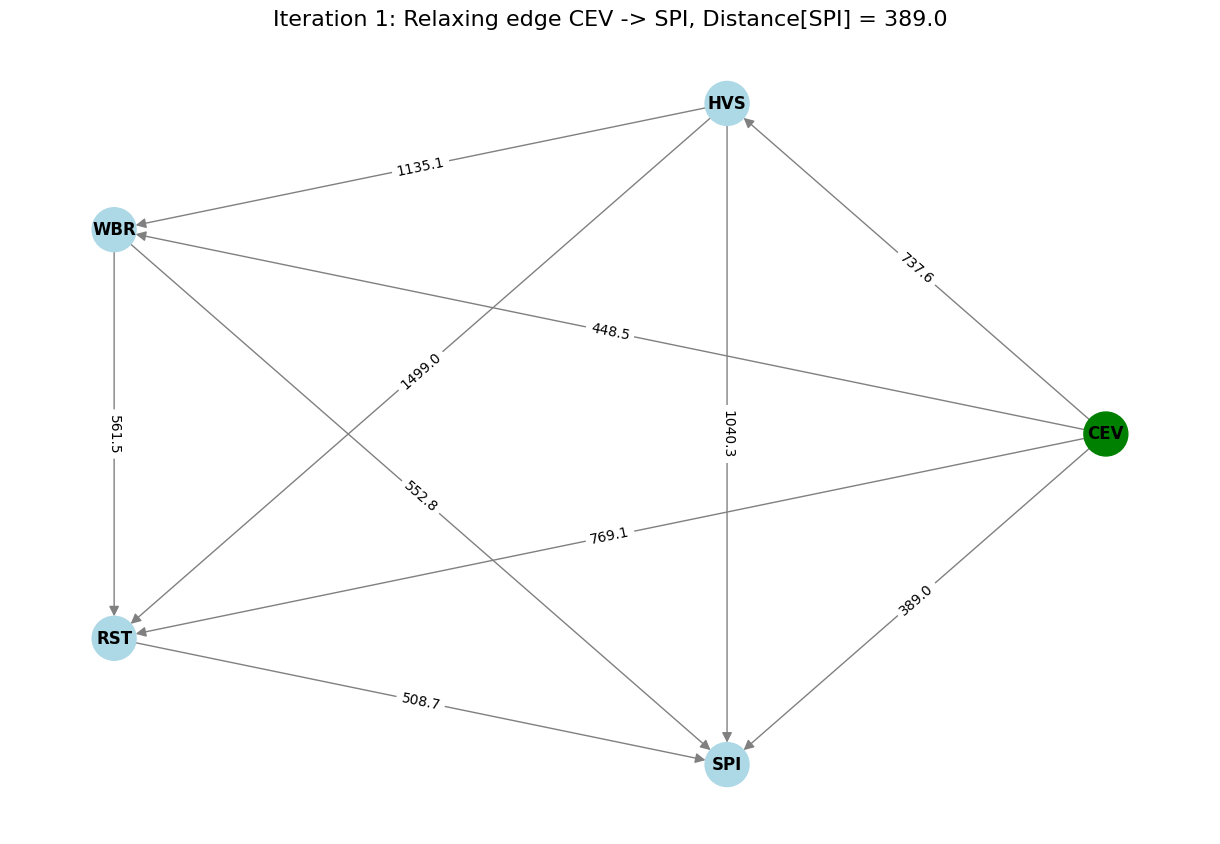

Iteration 2:
No updates in this iteration. Algorithm converged.
Final distances from source: {'CEV': 0, 'HVS': 737.6, 'WBR': 448.5, 'RST': 769.1, 'SPI': 389.0}


In [83]:

# Load distances and filter for 10 random airports
file_path = r"C:\Users\sudersanamv\vs code\BELLMAN-FORD-ALGORITHM\28k airports data\airport_distances.json"  
all_distances = load_distances(file_path)
filtered_distances = select_random_airports(all_distances, num_airports=5)

# Create graph for the selected airports
G = create_graph(filtered_distances)

# Visualize Bellman-Ford algorithm
source_airport = random.choice(list(G.nodes()))  # Select a random source airport
print(f"Selected source airport: {source_airport}")
visualize_bellman_ford(G, source_airport)
